In [29]:
import numpy as np
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

results = pd.read_csv('results.csv')
rankings = pd.read_csv('rankings.csv')

In [30]:
# Convert dates to datetime
rankings['rank_date'] = pd.to_datetime(rankings['rank_date'])
results['date'] = pd.to_datetime(results['date'])

# Drop data older than 20 years
cutoff_date = pd.to_datetime('today') - pd.DateOffset(years=20)
rankings = rankings[rankings['rank_date'] >= cutoff_date]
results = results[results['date'] >= cutoff_date]

# Replace 'Czechia' with 'Czech Republic'
rankings.replace({'Czechia': 'Czech Republic'}, inplace=True)

# Extract games of interest
euro_2024_games = results[results['date'] >= pd.to_datetime('2024-06-14')]

In [ ]:
def get_latest_ranking(team, date):
    team_rankings = rankings[rankings['country_full'] == team]
    team_rankings_before_date = team_rankings[team_rankings['rank_date'] <= date]
    if not team_rankings_before_date.empty:
        latest_ranking = team_rankings_before_date.iloc[-1]
        return latest_ranking[['rank', 'total_points', 'previous_points', 'rank_change']]
    else:
        return pd.Series([np.nan, np.nan, np.nan, np.nan], index=['rank', 'total_points', 'previous_points', 'rank_change'])

def compute_recent_form_stats(team, date):
    games_to_consider = 5
    past_matches = results[((results['home_team'] == team) | (results['away_team'] == team)) & (results['date'] < date)]
    past_matches = past_matches.iloc[-games_to_consider:]
    wins = past_matches.apply(lambda row: 1 if (row['home_team'] == team and row['home_score'] > row['away_score']) or (row['away_team'] == team and row['away_score'] > row['home_score']) else 0, axis=1).sum()
    goals_scored = past_matches.apply(lambda row: row['home_score'] if row['home_team'] == team else row['away_score'], axis=1).sum()
    goals_conceded = past_matches.apply(lambda row: row['away_score'] if row['home_team'] == team else row['home_score'], axis=1).sum()
    clean_sheets = past_matches.apply(lambda row: 1 if (row['home_team'] == team and row['away_score'] == 0) or (row['away_team'] == team and row['home_score'] == 0) else 0, axis=1).sum()

    return wins, goals_scored, goals_conceded, clean_sheets

def compute_head_to_head(home_team, away_team, date):
    head_to_head_matches = results[((results['home_team'] == home_team) & (results['away_team'] == away_team)) | ((results['home_team'] == away_team) & (results['away_team'] == home_team)) & (results['date'] < date)]
    head_to_head_matches = head_to_head_matches.sort_values(by='date', ascending=False)
    wins = head_to_head_matches.apply(lambda row: 1 if (row['home_team'] == home_team and row['home_score'] > row['away_score']) or (row['away_team'] == home_team and row['away_score'] > row['home_score']) else 0, axis=1).sum()
    losses = head_to_head_matches.apply(lambda row: 1 if (row['home_team'] == home_team and row['home_score'] < row['away_score']) or (row['away_team'] == home_team and row['away_score'] < row['home_score']) else 0, axis=1).sum()
    draws = head_to_head_matches.apply(lambda row: 1 if row['home_score'] == row['away_score'] else 0, axis=1).sum()
    goals_scored = head_to_head_matches.apply(lambda row: row['home_score'] if row['home_team'] == home_team else row['away_score'], axis=1).sum()
    goals_conceded = head_to_head_matches.apply(lambda row: row['home_score'] if row['home_team'] == away_team else row['away_score'], axis=1).sum()

    return wins, losses, draws, goals_scored, goals_conceded

def extract_features(df):
    features = pd.DataFrame()

    # Basic ranking features
    features['home_team_rank'] = df['home_team_rank']
    features['away_team_rank'] = df['away_team_rank']
    features['home_team_total_points'] = df['home_team_total_points']
    features['away_team_total_points'] = df['away_team_total_points']
    features['home_team_previous_points'] = df['home_team_previous_points']
    features['away_team_previous_points'] = df['away_team_previous_points']
    features['home_team_rank_change'] = df['home_team_rank_change']
    features['away_team_rank_change'] = df['away_team_rank_change']
    features['rank_difference'] = df['home_team_rank'] - df['away_team_rank']
    features['point_difference'] = df['home_team_total_points'] - df['away_team_total_points']
    features['average_rank'] = (df['home_team_rank'] + df['away_team_rank']) / 2

    # recent form
    features[['recent_home_team_wins', 'recent_home_team_goals_scored', 'recent_home_team_goals_conceded', 'recent_home_team_clean_sheets']] = df.apply(
        lambda row: pd.Series(compute_recent_form_stats(row['home_team'], row['date'])), axis=1)
    features[['recent_away_team_wins', 'recent_away_team_goals_scored', 'recent_away_team_goals_conceded', 'recent_away_team_clean_sheets']] = df.apply(
        lambda row: pd.Series(compute_recent_form_stats(row['away_team'], row['date'])), axis=1)

    # H2H
    features[['home_team_h2h_wins', 'home_team_h2h_losses', 'home_team_h2h_draws', 'home_team_h2h_goals_scored', 'home_team_h2h_goals_conceded' ]] = df.apply(
        lambda row: pd.Series(compute_head_to_head(row['home_team'],row['away_team'], row['date'])), axis=1)

    return features

In [ ]:
# Add rankings
results[['home_team_rank', 'home_team_total_points', 'home_team_previous_points', 'home_team_rank_change']] = results.apply(
    lambda row: get_latest_ranking(row['home_team'], row['date']), axis=1)
results[['away_team_rank', 'away_team_total_points', 'away_team_previous_points', 'away_team_rank_change']] = results.apply(
    lambda row: get_latest_ranking(row['away_team'], row['date']), axis=1)

# Extract features
features = extract_features(results)
result_features = pd.concat([results, features], axis=1)

In [148]:
# Splitting the data into training and testing sets
from sklearn.model_selection import train_test_split
data = result_features.dropna()

scores_df = pd.DataFrame({'home_score': data['home_score'], 'away_score': data['away_score']})
features_df = data[['home_team_rank', 'away_team_rank', 'home_team_total_points', 'away_team_total_points', 'home_team_previous_points', 'away_team_previous_points', 'home_team_rank_change',
                   'away_team_rank_change', 'rank_difference', 'point_difference', 'average_rank', 'recent_home_team_wins','recent_home_team_goals_scored', 'recent_home_team_goals_conceded',
                   'recent_home_team_clean_sheets', 'recent_away_team_wins', 'recent_away_team_goals_scored', 'recent_away_team_goals_conceded', 'recent_away_team_clean_sheets',
                   'home_team_h2h_wins', 'home_team_h2h_losses', 'home_team_h2h_draws', 'home_team_h2h_goals_scored', 'home_team_h2h_goals_conceded']]
features_df = features_df.loc[:,~features_df.columns.duplicated()].copy()

X_train, X_test, y_train, y_test = train_test_split(features_df, scores_df, test_size=0.2, random_state=0)

In [9]:
# Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import Lasso

scaler = StandardScaler()
X_train_lasso , X_test_lasso= scaler.fit_transform(X_train), scaler.fit_transform(X_test)

# Define the Lasso Regression model
lasso_model = Lasso(alpha=0.1)

# Train the model
lasso_model.fit(X_train_lasso, y_train)

# Make predictions
y_pred = lasso_model.predict(X_test_lasso)

# Round the predicted scores to natural numbers
y_pred_rounded = np.round(y_pred).astype(int)

# Evaluate the model
test_rmse_lasso = mean_squared_error(y_test, y_pred_rounded, squared=False)
test_mae_lasso = mean_absolute_error(y_test, y_pred_rounded)

print("RMSE:", test_rmse_lasso)
print("MAE:", test_mae_lasso)

RMSE: 1.2093547996651441
MAE: 0.8365289256198347


In [10]:
# Random forest
from sklearn.ensemble import RandomForestRegressor

# Define the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=0)

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Round the predicted scores to natural numbers
y_pred_rounded = np.round(y_pred).astype(int)

# Evaluate the model
test_rmse_rf = mean_squared_error(y_test, y_pred_rounded, squared=False)
test_mae_rf = mean_absolute_error(y_test, y_pred)

print("RMSE:", test_rmse_rf)
print("MAE:", test_mae_rf)

RMSE: 1.0260126867350707
MAE: 0.681160330578512


In [11]:
# gradient boosted tree
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import GradientBoostingRegressor

# Training the Gradient Boosted Tree model
gbt_model = MultiOutputRegressor(GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=0))
gbt_model.fit(X_train, y_train)

# Making predictions
y_pred_train = gbt_model.predict(X_train)
y_pred = gbt_model.predict(X_test)

# Round the predicted scores to natural numbers
y_pred_rounded = np.round(y_pred).astype(int)

# Evaluating the model
test_rmse_gb = mean_squared_error(y_test, y_pred_rounded, squared=False)
test_mae_gb = mean_absolute_error(y_test, y_pred_rounded)

print("RMSE:", test_rmse_gb)
print("MAE:", test_mae_gb)

RMSE: 1.0011024828040962
MAE: 0.6423140495867768


In [13]:
# MLP
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
scaler = StandardScaler()
X_train_mlp , X_test_mlp= scaler.fit_transform(X_train), scaler.fit_transform(X_test)

# Define the MLP model
mlp_model = Sequential()
mlp_model.add(Dense(128, activation='relu'))
mlp_model.add(Dropout(0.2))
mlp_model.add(Dense(64, activation='relu'))
mlp_model.add(Dropout(0.2))
mlp_model.add(Dense(2))  # Output layer with 2 neurons for home and away scores

# Compile the model
mlp_model.compile(optimizer='adam', loss='mse')

# Train the model
history = mlp_model.fit(X_train_mlp, y_train, epochs=50, batch_size=32, validation_data=(X_test_mlp, y_test), verbose=1)

# Evaluate the model
y_pred = mlp_model.predict(X_test_mlp)

# Round the predicted scores to natural numbers
y_pred_rounded = np.round(y_pred).astype(int)

test_rmse_mlp = mean_squared_error(y_test, y_pred_rounded, squared=False)
test_mae_mlp = mean_absolute_error(y_test, y_pred_rounded)

print("RMSE:", test_rmse_mlp)
print("MAE:", test_mae_mlp)

Epoch 1/50
379/379 [==============================] - 2s 3ms/step - loss: 1.5138 - val_loss: 1.2055
Epoch 2/50
379/379 [==============================] - 1s 3ms/step - loss: 1.2207 - val_loss: 1.0902
Epoch 3/50
379/379 [==============================] - 1s 3ms/step - loss: 1.1177 - val_loss: 1.0042
Epoch 4/50
379/379 [==============================] - 1s 2ms/step - loss: 1.0586 - val_loss: 1.0112
Epoch 5/50
379/379 [==============================] - 1s 3ms/step - loss: 1.0228 - val_loss: 0.9510
Epoch 6/50
379/379 [==============================] - 2s 4ms/step - loss: 0.9904 - val_loss: 0.9396
Epoch 7/50
379/379 [==============================] - 2s 4ms/step - loss: 0.9761 - val_loss: 0.9355
Epoch 8/50
379/379 [==============================] - 1s 3ms/step - loss: 0.9672 - val_loss: 0.9258
Epoch 9/50
379/379 [==============================] - 1s 3ms/step - loss: 0.9509 - val_loss: 0.9044
Epoch 10/50
379/379 [==============================] - 1s 3ms/step - loss: 0.9481 - val_loss: 0.9046

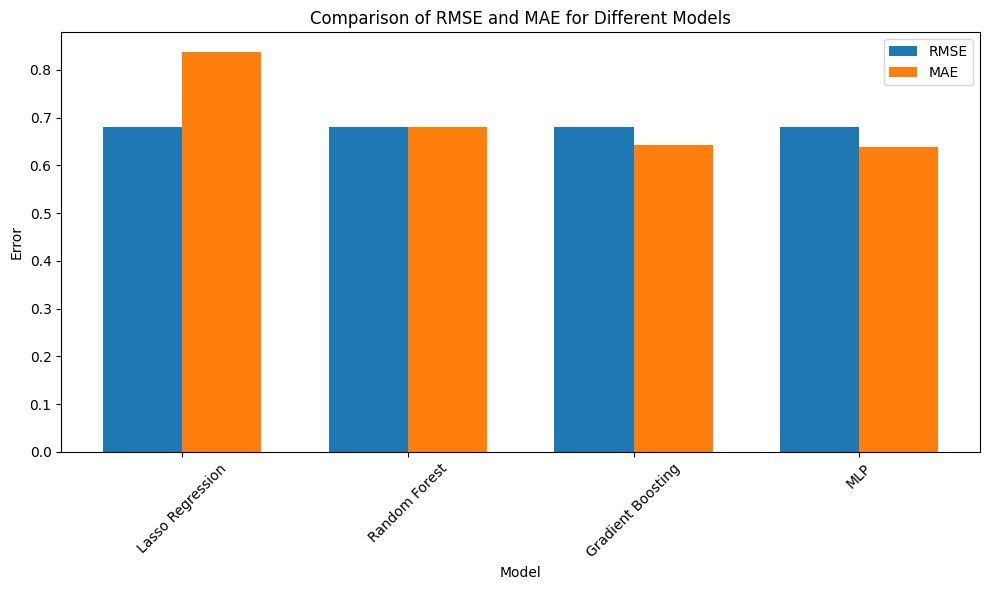

In [136]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming test_rmse and test_mae are lists containing RMSE and MAE values for different models

models = ['Lasso Regression', 'Random Forest', 'Gradient Boosting', 'MLP']
test_rmse_values = [test_rmse_lasso, test_rmse_rf, test_rmse_gb, test_rmse_mlp]
test_mae_values = [test_mae_lasso, test_mae_rf, test_mae_gb, test_mae_mlp]

x = np.arange(len(models))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))

bar1 = ax.bar(x - width/2, test_mae_rf, width, label='RMSE')
bar2 = ax.bar(x + width/2, test_mae_values, width, label='MAE')

ax.set_title('Comparison of RMSE and MAE for Different Models')
ax.set_xlabel('Model')
ax.set_ylabel('Error')
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=45)
ax.legend()

fig.tight_layout()

plt.show()

In [14]:
# average
y_pred = (mlp_model.predict(X_test_mlp) + gbt_model.predict(X_test) + rf_model.predict(X_test))/3

# Round the predicted scores to natural numbers
y_pred_rounded = np.round(y_pred).astype(int)

test_rmse_average = mean_squared_error(y_test, y_pred_rounded, squared=False)
test_mae_average = mean_absolute_error(y_test, y_pred_rounded)

print("RMSE:", test_rmse_average)
print("MAE:", test_mae_average)

95/95 [==============================] - 0s 1ms/step
RMSE: 0.986342790882186
MAE: 0.6295867768595041


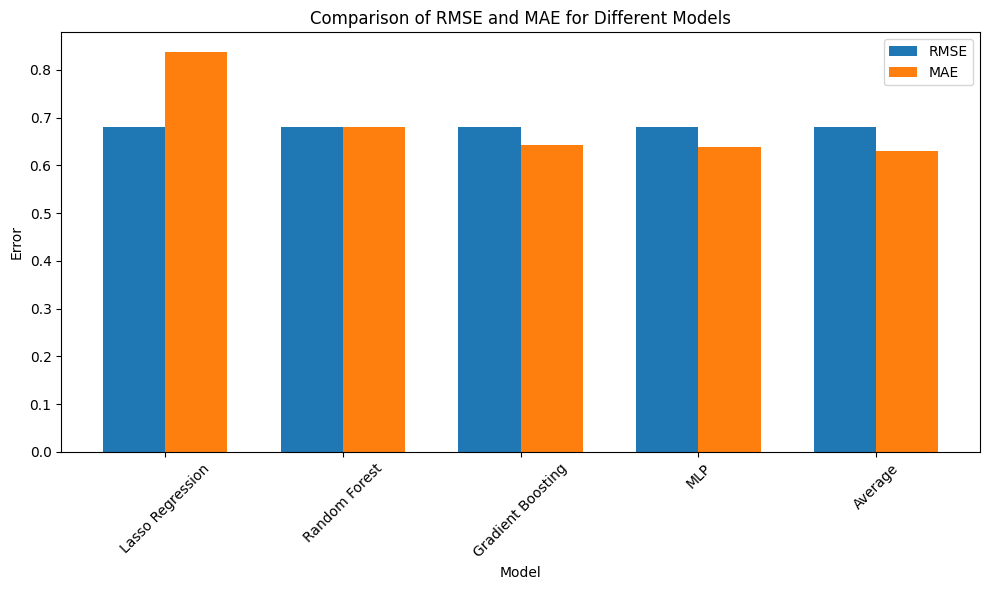

In [138]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming test_rmse and test_mae are lists containing RMSE and MAE values for different models

models = ['Lasso Regression', 'Random Forest', 'Gradient Boosting', 'MLP', 'Average']
test_rmse_values = [test_rmse_lasso, test_rmse_rf, test_rmse_gb, test_rmse_mlp, test_rmse_average]
test_mae_values = [test_mae_lasso, test_mae_rf, test_mae_gb, test_mae_mlp, test_mae_average]

x = np.arange(len(models))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))

bar1 = ax.bar(x - width/2, test_mae_rf, width, label='RMSE')
bar2 = ax.bar(x + width/2, test_mae_values, width, label='MAE')

ax.set_title('Comparison of RMSE and MAE for Different Models')
ax.set_xlabel('Model')
ax.set_ylabel('Error')
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=45)
ax.legend()

fig.tight_layout()

plt.show()


Therefore, based on the comparable performance of these models, I somewhat arbitrarily decided to proceed with the MLP model.

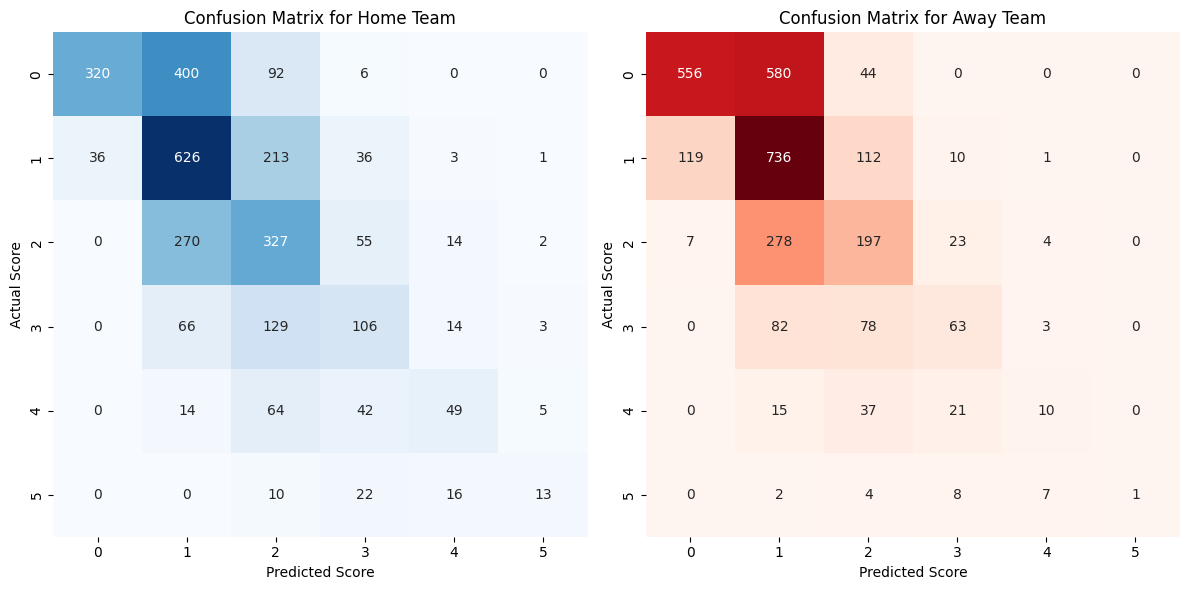

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Convert predicted and actual scores to rounded integers
y_pred_rounded = np.round(y_pred).astype(int)
y_test_rounded = np.round(y_test).astype(int)

# Compute confusion matrices for home and away teams
conf_matrix_home = confusion_matrix(y_test['home_score'], y_pred_rounded[:, 0])
conf_matrix_away = confusion_matrix(y_test['away_score'], y_pred_rounded[:, 1])

# Define a function to plot heatmap for better code reuse
def plot_heatmap(conf_matrix, title, cmap, ax):
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=cmap, cbar=False, ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Predicted Score')
    ax.set_ylabel('Actual Score')
    ax.set_xticks(np.arange(len(conf_matrix)) + 0.5)
    ax.set_yticks(np.arange(len(conf_matrix)) + 0.5)
    ax.set_xticklabels(np.arange(len(conf_matrix)))
    ax.set_yticklabels(np.arange(len(conf_matrix)))

# Plot heatmaps
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

plot_heatmap(conf_matrix_home[:6,:6], 'Confusion Matrix for Home Team', 'Blues', axs[0])
plot_heatmap(conf_matrix_away[:6,:6], 'Confusion Matrix for Away Team', 'Reds', axs[1])

plt.tight_layout()
plt.show()

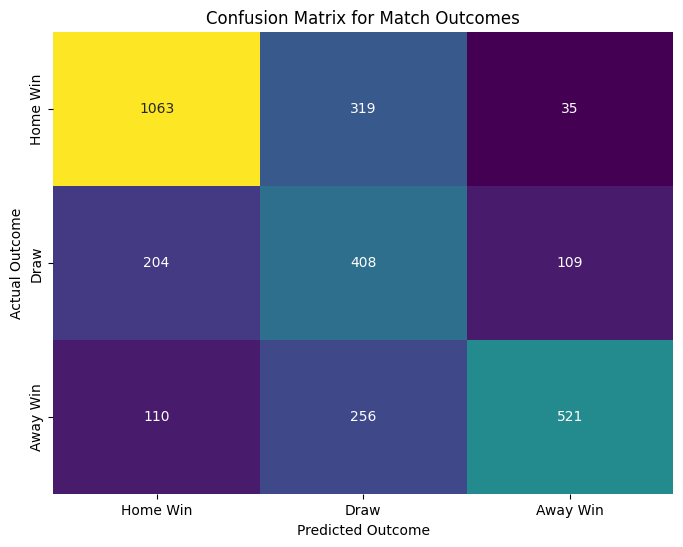

In [139]:
# Define a function to determine match outcomes
def get_match_outcome(home_score, away_score):
    if home_score > away_score:
        return 'Home Win'
    elif home_score < away_score:
        return 'Away Win'
    else:
        return 'Draw'

# Apply the function to actual and predicted scores
y_test_outcomes = [get_match_outcome(home, away) for home, away in zip(y_test['home_score'], y_test['away_score'])]
y_pred_outcomes = [get_match_outcome(home, away) for home, away in y_pred_rounded]

# Create the confusion matrix for match outcomes
outcome_labels = ['Home Win', 'Draw', 'Away Win']
conf_matrix_outcomes = confusion_matrix(y_test_outcomes, y_pred_outcomes, labels=outcome_labels)

# Plot the heatmap for match outcomes
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_outcomes, annot=True, fmt='d', cmap='viridis', cbar=False,
            xticklabels=outcome_labels, yticklabels=outcome_labels)
plt.title('Confusion Matrix for Match Outcomes')
plt.xlabel('Predicted Outcome')
plt.ylabel('Actual Outcome')
plt.show()

In [436]:
# Compute exact score prediction accuracy
exact_score_accuracy = np.mean((y_test['home_score'] == y_pred_rounded[:, 0]) & (y_test['away_score'] == y_pred_rounded[:, 1]))

# Compute goal difference prediction accuracy
actual_goal_diff = y_test['home_score'] - y_test['away_score']
predicted_goal_diff = y_pred_rounded[:, 0] - y_pred_rounded[:, 1]
goal_diff_accuracy = np.mean(actual_goal_diff == predicted_goal_diff)

# Compute match winner prediction accuracy
winner_accuracy = np.mean(np.array(y_test_outcomes) == np.array(y_pred_outcomes))

print(f'Exact Score Prediction Accuracy: {exact_score_accuracy:.2%}')
print(f'Goal Difference Prediction Accuracy: {goal_diff_accuracy:.2%}')
print(f'Match Winner Prediction Accuracy: {winner_accuracy:.2%}')

Exact Score Prediction Accuracy: 28.60%
Goal Difference Prediction Accuracy: 39.90%
Match Winner Prediction Accuracy: 65.85%


In [426]:
# Simulate group stage

# Group stage games
group_stage_games = euro_2024_games.copy()

# Define the end dates for each game day
end_dates = ['2024-06-18', '2024-06-22', '2024-06-26']
end_dates = pd.to_datetime(end_dates)

# Add ranking info for home_team
group_stage_games[['home_team_rank', 'home_team_total_points', 'home_team_previous_points', 'home_team_rank_change']] = group_stage_games.apply(
    lambda row: get_latest_ranking(row['home_team'], row['date']), axis=1)

# Add ranking info for away_team
group_stage_games[['away_team_rank', 'away_team_total_points', 'away_team_previous_points', 'away_team_rank_change']] = group_stage_games.apply(
    lambda row: get_latest_ranking(row['away_team'], row['date']), axis=1)

# Extract games for each game day
game_day_1_games = group_stage_games[group_stage_games['date'] <= end_dates[0]]
game_day_2_games = group_stage_games[(group_stage_games['date'] > end_dates[0]) & (group_stage_games['date'] <= end_dates[1])]
game_day_3_games = group_stage_games[(group_stage_games['date'] > end_dates[1]) & (group_stage_games['date'] <= end_dates[2])]

# Initialize a dictionary to store results
group_stage_results = {team: {'points': 0, 'goal_difference': 0, 'goals_scored': 0} for team in set(group_stage_games['home_team']).union(set(group_stage_games['away_team']))}

def update_group_stage_results(games, model, group_stage_results):
      # Extract features for the game
      game_features = games[['home_team_rank', 'away_team_rank', 'home_team_total_points', 'away_team_total_points', 'home_team_previous_points', 'away_team_previous_points', 'home_team_rank_change',
                  'away_team_rank_change', 'rank_difference', 'point_difference', 'average_rank', 'recent_home_team_wins','recent_home_team_goals_scored', 'recent_home_team_goals_conceded',
                  'recent_home_team_clean_sheets', 'recent_away_team_wins', 'recent_away_team_goals_scored', 'recent_away_team_goals_conceded', 'recent_away_team_clean_sheets',
                  'home_team_h2h_wins', 'home_team_h2h_losses', 'home_team_h2h_draws', 'home_team_h2h_goals_scored', 'home_team_h2h_goals_conceded']]

      scaler = StandardScaler()
      scaler.fit(X_train.values)
      game_features_scaled = scaler.transform(game_features)

      # Predict the score
      predicted_score = model.predict(game_features_scaled)
      predicted_home_score, predicted_away_score = np.rint(predicted_score[:,0]),np.rint(predicted_score[:,1])

      for counter, (_,game) in enumerate(games.iterrows()):

        # Update results matrix
        home_team = game['home_team']
        away_team = game['away_team']

        group_stage_results[home_team]['goals_scored'] += predicted_home_score[counter]
        group_stage_results[away_team]['goals_scored'] += predicted_away_score[counter]
        group_stage_results[home_team]['goal_difference'] += (predicted_home_score[counter] - predicted_away_score[counter])
        group_stage_results[away_team]['goal_difference'] += (predicted_away_score[counter] - predicted_home_score[counter])

        if predicted_home_score[counter] > predicted_away_score[counter]:
            group_stage_results[home_team]['points'] += 3
        elif predicted_home_score[counter] < predicted_away_score[counter]:
            group_stage_results[away_team]['points'] += 3
        else:
            group_stage_results[home_team]['points'] += 1
            group_stage_results[away_team]['points'] += 1

        # Update results DataFrame
        results.loc[(results['date'] == game['date']) & (results['home_team'] == home_team), 'home_score'] = predicted_home_score[counter]
        results.loc[(results['date'] == game['date']) & (results['away_team'] == away_team), 'away_score'] = predicted_away_score[counter]

# Initialize the model (assuming the MLP model is named 'mlp_model')
model = mlp_model

# Simulate the first game day
game_day_1_games_features = extract_features(game_day_1_games)
game_day_1_games = pd.concat([game_day_1_games, game_day_1_games_features], axis=1)
game_day_1_games = game_day_1_games.loc[:,~game_day_1_games.columns.duplicated()].copy()
update_group_stage_results(game_day_1_games, model, group_stage_results)

# Simulate the second game day
game_day_2_games_features = extract_features(game_day_2_games)
game_day_2_games = pd.concat([game_day_2_games, game_day_2_games_features], axis=1)
game_day_2_games = game_day_2_games.loc[:,~game_day_2_games.columns.duplicated()].copy()
update_group_stage_results(game_day_2_games, model, group_stage_results)

#Simulate the third game day
game_day_3_games_features = extract_features(game_day_3_games)
game_day_3_games = pd.concat([game_day_3_games, game_day_3_games_features], axis=1)
game_day_3_games = game_day_3_games.loc[:,~game_day_3_games.columns.duplicated()].copy()
update_group_stage_results(game_day_3_games, model, group_stage_results)
group_stage_results

1/1 [==============================] - 0s 35ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


1/1 [==============================] - 0s 28ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


1/1 [==============================] - 0s 25ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


{'Austria': {'points': 1, 'goal_difference': -3.0, 'goals_scored': 3.0},
 'Slovakia': {'points': 5, 'goal_difference': 1.0, 'goals_scored': 5.0},
 'Ukraine': {'points': 4, 'goal_difference': 0.0, 'goals_scored': 5.0},
 'Poland': {'points': 3, 'goal_difference': -1.0, 'goals_scored': 3.0},
 'Portugal': {'points': 7, 'goal_difference': 4.0, 'goals_scored': 6.0},
 'Netherlands': {'points': 6, 'goal_difference': 2.0, 'goals_scored': 6.0},
 'Germany': {'points': 9, 'goal_difference': 3.0, 'goals_scored': 8.0},
 nan: {'points': 0, 'goal_difference': 0, 'goals_scored': 0},
 'Croatia': {'points': 2, 'goal_difference': -1.0, 'goals_scored': 3.0},
 'Switzerland': {'points': 6, 'goal_difference': 2.0, 'goals_scored': 8.0},
 'France': {'points': 7, 'goal_difference': 2.0, 'goals_scored': 4.0},
 'Georgia': {'points': 1, 'goal_difference': -3.0, 'goals_scored': 2.0},
 'Serbia': {'points': 2, 'goal_difference': -3.0, 'goals_scored': 2.0},
 'Belgium': {'points': 5, 'goal_difference': 1.0, 'goals_score

In [427]:
# Define the groups and the teams in each group
groups = {
    'Group A': ['Scotland', 'Germany', 'Switzerland', 'Hungary'],
    'Group B': ['Albania', 'Croatia', 'Spain', 'Italy'],
    'Group C': ['Slovenia', 'Serbia', 'England', 'Denmark'],
    'Group D': ['Poland', 'France', 'Netherlands', 'Austria'],
    'Group E': ['Romania', 'Ukraine', 'Slovakia', 'Belgium'],
    'Group F': ['Georgia', 'Turkey', 'Czech Republic', 'Portugal']
}

# Function to get rankings within each group
def get_group_rankings(group_stage_results, groups):
    group_rankings = {}

    for group_name, teams in groups.items():
        group_data = []

        # Gather the group data
        for team in teams:
            if team in group_stage_results:
                group_data.append({
                    'team': team,
                    'points': group_stage_results[team]['points'],
                    'goal_difference': group_stage_results[team]['goal_difference'],
                    'goals_scored': group_stage_results[team]['goals_scored']
                })

        # Convert to DataFrame for easy sorting and ranking
        group_df = pd.DataFrame(group_data)

        # Sort by points, then goal difference, then goals scored
        group_df = group_df.sort_values(by=['points', 'goal_difference', 'goals_scored'], ascending=[False, False, False])

        # Add rank column
        group_df['rank'] = range(1, len(group_df) + 1)

        # Save the group rankings
        group_rankings[group_name] = group_df

    return group_rankings

# Get the rankings
group_rankings = get_group_rankings(group_stage_results, groups)

# Print the rankings for each group
for group_name, ranking_df in group_rankings.items():
    print(f"Rankings for {group_name}:")
    print(ranking_df)
    print("\n")


Rankings for Group A:
          team  points  goal_difference  goals_scored  rank
1      Germany       9              3.0           8.0     1
2  Switzerland       6              2.0           8.0     2
0     Scotland       1             -2.0           4.0     3
3      Hungary       1             -3.0           4.0     4


Rankings for Group B:
      team  points  goal_difference  goals_scored  rank
2    Spain       7              3.0           5.0     1
3    Italy       5              2.0           4.0     2
1  Croatia       2             -1.0           3.0     3
0  Albania       1             -4.0           1.0     4


Rankings for Group C:
       team  points  goal_difference  goals_scored  rank
3   Denmark       7              4.0           6.0     1
2   England       3              0.0           3.0     2
0  Slovenia       2             -1.0           3.0     3
1    Serbia       2             -3.0           2.0     4


Rankings for Group D:
          team  points  goal_difference  

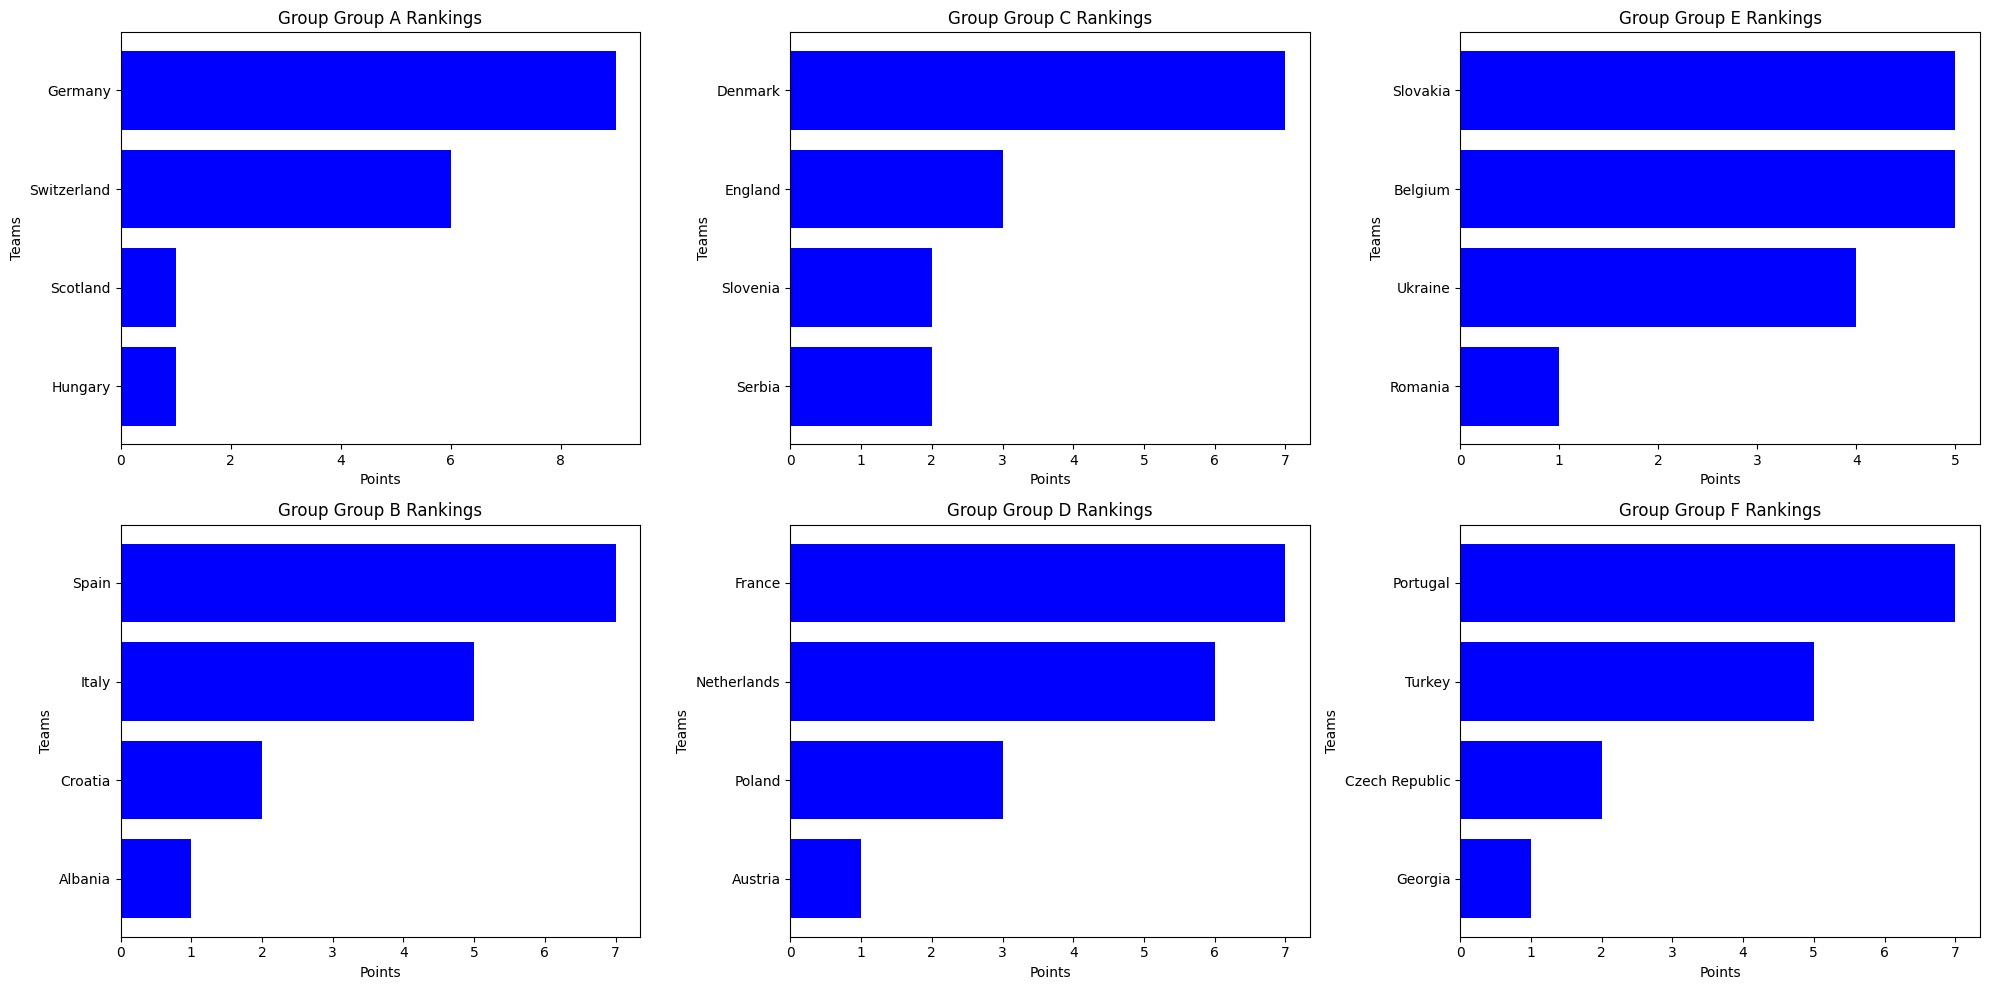

In [428]:
# Define a function to visualize group rankings
def plot_group_rankings(group_rankings):
    fig, axs = plt.subplots(2, 3, figsize=(20, 10))

    for i, (group_name, ranking_df) in enumerate(group_rankings.items()):
        row = i % 2
        col = i // 2

        axs[row, col].barh(ranking_df['team'], ranking_df['points'], color='blue')
        axs[row, col].set_xlabel('Points')
        axs[row, col].set_ylabel('Teams')
        axs[row, col].set_title(f'Group {group_name} Rankings')
        axs[row, col].invert_yaxis()  # Invert y-axis to show the top-ranked team at the top

    plt.tight_layout()
    plt.show()

# Visualize group rankings
plot_group_rankings(group_rankings)

In [429]:
# Function to get the top 2 teams and the best third-placed teams from each group
def get_qualified_teams(group_rankings):
    top_teams = {}
    third_placed_teams = []

    for group_name, ranking_df in group_rankings.items():
        # Top 2 teams
        top_teams[f'1{group_name[-1]}'] = ranking_df.iloc[0]['team']
        top_teams[f'2{group_name[-1]}'] = ranking_df.iloc[1]['team']

        # Third-placed team
        third_placed_teams.append({
            'team': ranking_df.iloc[2]['team'],
            'points': ranking_df.iloc[2]['points'],
            'goal_difference': ranking_df.iloc[2]['goal_difference'],
            'goals_scored': ranking_df.iloc[2]['goals_scored'],
            'group': group_name[-1]
        })

    # Sort third-placed teams to get the best 4
    third_placed_df = pd.DataFrame(third_placed_teams)
    third_placed_df = third_placed_df.sort_values(by=['points', 'goal_difference', 'goals_scored'], ascending=[False, False, False])

    best_third_teams = third_placed_df.iloc[:4]['team'].values
    best_third_groups = third_placed_df.iloc[:4]['group'].values

    return top_teams, best_third_teams, best_third_groups

# Get the qualified teams
top_teams, best_third_teams, best_third_groups = get_qualified_teams(group_rankings)

# Print qualified teams for verification
print("Top Teams:", top_teams)
print("Best Third-Placed Teams:", best_third_teams)
print("Best Third-Placed Groups:", best_third_groups)

Top Teams: {'1A': 'Germany', '2A': 'Switzerland', '1B': 'Spain', '2B': 'Italy', '1C': 'Denmark', '2C': 'England', '1D': 'France', '2D': 'Netherlands', '1E': 'Slovakia', '2E': 'Belgium', '1F': 'Portugal', '2F': 'Turkey'}
Best Third-Placed Teams: ['Ukraine' 'Poland' 'Croatia' 'Slovenia']
Best Third-Placed Groups: ['E' 'D' 'B' 'C']


In [430]:
# Define the playoff match schedule and third-place combinations
playoff_matches = [
    ('2024-06-29', '18:00', 'Berlin', '2A', '2B'),
    ('2024-06-29', '21:00', 'Dortmund', '1A', '2C'),
    ('2024-06-30', '18:00', 'Gelsenkirchen', '1C', None),
    ('2024-06-30', '21:00', 'Cologne', '1B', None),
    ('2024-07-01', '18:00', 'Düsseldorf', '1F', None),
    ('2024-07-01', '21:00', 'Frankfurt', '2D', '2E'),
    ('2024-07-02', '18:00', 'Munich', '1E', None),
    ('2024-07-02', '21:00', 'Leipzig', '1D', '2F')
]

# Define the mapping for third-place matchups
third_place_matchups = {
    ('A', 'B', 'C', 'D'): [('3A', '1B'), ('3D', '1C'), ('3B', '1E'), ('3C', '1F')],
    ('A', 'B', 'C', 'E'): [('3A', '1B'), ('3E', '1C'), ('3B', '1E'), ('3C', '1F')],
    ('A', 'B', 'C', 'F'): [('3A', '1B'), ('3F', '1C'), ('3B', '1E'), ('3C', '1F')],
    ('A', 'B', 'D', 'E'): [('3D', '1B'), ('3E', '1C'), ('3A', '1E'), ('3B', '1F')],
    ('A', 'B', 'D', 'F'): [('3D', '1B'), ('3F', '1C'), ('3A', '1E'), ('3B', '1F')],
    ('A', 'B', 'E', 'F'): [('3E', '1B'), ('3F', '1C'), ('3B', '1E'), ('3A', '1F')],
    ('A', 'C', 'D', 'E'): [('3E', '1A'), ('3D', '1C'), ('3C', '1E'), ('3A', '1F')],
    ('A', 'C', 'D', 'F'): [('3F', '1A'), ('3D', '1C'), ('3C', '1E'), ('3A', '1F')],
    ('A', 'C', 'E', 'F'): [('3E', '1A'), ('3F', '1C'), ('3C', '1E'), ('3A', '1F')],
    ('A', 'D', 'E', 'F'): [('3E', '1A'), ('3F', '1C'), ('3D', '1E'), ('3A', '1F')],
    ('B', 'C', 'D', 'E'): [('3E', '1B'), ('3D', '1C'), ('3B', '1E'), ('3C', '1F')],
    ('B', 'C', 'D', 'F'): [('3F', '1B'), ('3D', '1C'), ('3B', '1E'), ('3C', '1F')],
    ('B', 'C', 'E', 'F'): [('3F', '1B'), ('3E', '1C'), ('3B', '1E'), ('3C', '1F')],
    ('B', 'D', 'E', 'F'): [('3F', '1B'), ('3E', '1C'), ('3D', '1E'), ('3B', '1F')],
    ('C', 'D', 'E', 'F'): [('3F', '1C'), ('3E', '1D'), ('3D', '1E'), ('3C', '1F')]
}

# Determine the third-place matchups for the best third-placed groups
best_third_groups_tuple = tuple(sorted(best_third_groups))
third_place_matchup = third_place_matchups[best_third_groups_tuple]

# Update the corresponding playoff matches with the third-place teams
for i, (third, first) in enumerate(third_place_matchup):
    for j, match in enumerate(playoff_matches):
        if match[4] == None and match[3] == first:
          playoff_matches[j] = (match[0], match[1], match[2], match[3], third)

# Function to update the results matrix with the qualified teams
def update_playoff_results_matrix(results, playoff_matches, top_teams, best_third_teams, third_place_matchup):
    results_updated = results.copy()
    third_place_lookup = {f'3{group}': team for group, team in zip(best_third_groups, best_third_teams)}

    # Iterate over each match in the playoff schedule
    for i, match in enumerate(playoff_matches):
        date, time, city, home_key, away_key = match

        # Determine the home and away teams
        if home_key and home_key.startswith('3'):
            home_team = third_place_lookup[home_key]
        else:
            home_team = top_teams[home_key]

        if away_key and away_key.startswith('3'):
            away_team = third_place_lookup[away_key]
        else:
            away_team = top_teams[away_key]

        if home_key is None:
            # Determine the home team from third place matchup
            for home_third, away in third_place_matchup:
                if away_key == away:
                    home_team = third_place_lookup[home_third]
                    break

        if away_key is None:
            # Determine the away team from third place matchup
            for home, away_third in third_place_matchup:
                if home_key == home:
                    away_team = third_place_lookup[away_third]
                    break
        if home_team == 'Germany':
          results_updated.loc[(results_updated['date'] == pd.to_datetime(date)) & (results_updated['city'] == city), 'neutral'] = False

        elif away_team == 'Germany':
          away_team = home_team
          home_team = 'Germany'
          results_updated.loc[(results_updated['date'] == pd.to_datetime(date)) & (results_updated['city'] == city), 'neutral'] = False

        # Update the results matrix with determined home and away teams
        results_updated.loc[(results_updated['date'] == pd.to_datetime(date)) & (results_updated['city'] == city), 'home_team'] = home_team
        results_updated.loc[(results_updated['date'] == pd.to_datetime(date)) & (results_updated['city'] == city), 'away_team'] = away_team

    return results_updated

# Example results dataframe
results_new = pd.DataFrame({
    'date': pd.to_datetime(['2024-06-29', '2024-06-29', '2024-06-30', '2024-06-30', '2024-07-01', '2024-07-01', '2024-07-02', '2024-07-02']),
    'home_team': [None] * 8,
    'away_team': [None] * 8,
    'home_score': [None] * 8,
    'away_score': [None] * 8,
    'tournament': ['UEFA Euro'] * 8,
    'city': ['Berlin', 'Dortmund', 'Gelsenkirchen', 'Cologne', 'Düsseldorf', 'Frankfurt', 'Munich', 'Leipzig'],
    'country': ['Germany'] * 8,
    'neutral': ['False'] * 8,

})

# Update the results matrix for the playoffs
results = update_playoff_results_matrix(results, playoff_matches, top_teams, best_third_teams, third_place_matchup)

In [431]:
# Simulate round of 16

round_of_16 = results[(results['date'] >= pd.to_datetime('2024-06-29')) & (results['date'] <= pd.to_datetime('2024-07-02'))].copy()

# Add ranks
round_of_16[['home_team_rank', 'home_team_total_points', 'home_team_previous_points', 'home_team_rank_change']] = round_of_16.apply(
    lambda row: get_latest_ranking(row['home_team'], row['date']), axis=1)
round_of_16[['away_team_rank', 'away_team_total_points', 'away_team_previous_points', 'away_team_rank_change']] = round_of_16.apply(
    lambda row: get_latest_ranking(row['away_team'], row['date']), axis=1)

# Extract features
round_of_16_features = extract_features(round_of_16)

# Scaling
round_of_16_features_scaled = scaler.transform(round_of_16_features)

# Predict results
predicted_scores_round_of_16 = mlp_model.predict(round_of_16_features_scaled)

predicted_home_scores_round_of_16 = predicted_scores_round_of_16[:, 0]
predicted_away_scores_round_of_16 = predicted_scores_round_of_16[:, 1]

# Store the winners
round_of_16_winners = {}

# Function to simulate a penalty shootout
def simulate_penalty_shootout(home_team, away_team):
    # ToDo: add model to simulate penalties
    return np.random.choice([home_team, away_team])

for i, (_, row) in enumerate(round_of_16.iterrows()):
    home_team = row['home_team']
    away_team = row['away_team']
    home_score = predicted_home_scores_round_of_16[i]
    away_score = predicted_away_scores_round_of_16[i]

    # Update results DataFrame
    results.loc[(results['date'] == row['date']) & (results['home_team'] == home_team), 'home_score'] = home_score
    results.loc[(results['date'] == row['date']) & (results['away_team'] == away_team), 'away_score'] = away_score

    if home_score > away_score:
        winner = home_team
    elif away_score > home_score:
        winner = away_team
    else:
        winner = simulate_penalty_shootout(home_team, away_team)

    results.loc
    round_of_16_winners[i+1] = winner

# Print winners
for counter, (_, row) in enumerate(round_of_16.iterrows()):
    home_team = row['home_team']
    away_team = row['away_team']
    home_score = int(np.rint(row['home_score']))
    away_score = int(np.rint(row['away_score']))
    winner = round_of_16_winners[counter+1]
    print(f"{home_team} {home_score} : {away_score} {away_team} -> {winner} goes to next round")

1/1 [==============================] - 0s 25ms/step
Switzerland 1 : 1 Italy -> Italy goes to next round
Germany 2 : 1 England -> Germany goes to next round
Denmark 3 : 1 Poland -> Denmark goes to next round
Spain 3 : 0 Ukraine -> Spain goes to next round
Portugal 0 : 2 Slovenia -> Slovenia goes to next round
Netherlands 2 : 1 Belgium -> Netherlands goes to next round
Slovakia 1 : 2 Croatia -> Croatia goes to next round
France 1 : 1 Turkey -> France goes to next round


In [432]:
# Simulate the quarter-finals

# Extract quarter-final games from the results matrix
quarter_final_games = results[(results['date'] >= pd.to_datetime('2024-07-05')) & (results['date'] <= pd.to_datetime('2024-07-06'))].copy()

# Define the quarter-final pairings
quarter_final_pairings = {
    1: (round_of_16_winners[4], round_of_16_winners[2]),
    2: (round_of_16_winners[3], round_of_16_winners[1]),
    3: (round_of_16_winners[5], round_of_16_winners[7]),
    4: (round_of_16_winners[6], round_of_16_winners[8]),
}

# Update the quarter-final games with the correct teams
for game_number, teams in quarter_final_pairings.items():
    if teams[0] == 'Germany':
      quarter_final_games.loc[quarter_final_games.index[game_number-1], 'home_team'] = teams[0]
      quarter_final_games.loc[quarter_final_games.index[game_number-1], 'away_team'] = teams[1]
      quarter_final_games.loc[quarter_final_games.index[game_number-1], 'neutral'] = False
    elif teams[1] == 'Germany':
      quarter_final_games.loc[quarter_final_games.index[game_number-1], 'home_team'] = teams[1]
      quarter_final_games.loc[quarter_final_games.index[game_number-1], 'away_team'] = teams[0]
      quarter_final_games.loc[quarter_final_games.index[game_number-1], 'neutral'] = False
    else:
      quarter_final_games.loc[quarter_final_games.index[game_number-1], 'home_team'] = teams[0]
      quarter_final_games.loc[quarter_final_games.index[game_number-1], 'away_team'] = teams[1]

# Add ranks
quarter_final_games[['home_team_rank', 'home_team_total_points', 'home_team_previous_points', 'home_team_rank_change']] = quarter_final_games.apply(
    lambda row: get_latest_ranking(row['home_team'], row['date']), axis=1, result_type="expand")
quarter_final_games[['away_team_rank', 'away_team_total_points', 'away_team_previous_points', 'away_team_rank_change']] = quarter_final_games.apply(
    lambda row: get_latest_ranking(row['away_team'], row['date']), axis=1, result_type="expand")

# Extract features
quarter_final_features  = extract_features(quarter_final_games)

# Scaling
quarter_final_features_scaled  = scaler.transform(quarter_final_features)

# Predict results
predicted_scores_quarter_finals  = mlp_model.predict(quarter_final_features_scaled )

predicted_home_scores_quarter_finals  = predicted_scores_quarter_finals[:, 0]
predicted_away_scores_quarter_finals  = predicted_scores_quarter_finals[:, 1]

# Store the winners
quarter_final_winners  = {}

for i, (_, row) in enumerate(quarter_final_games.iterrows()):
    home_team = row['home_team']
    away_team = row['away_team']
    home_score = predicted_home_scores_quarter_finals[i]
    away_score = predicted_away_scores_quarter_finals[i]

    # Update results DataFrame
    results.loc[(results['date'] == row['date']) & (results['city'] == row['city']), 'home_team'] = home_team
    results.loc[(results['date'] == row['date']) & (results['city'] == row['city']), 'home_score'] = home_score
    results.loc[(results['date'] == row['date']) & (results['city'] == row['city']), 'away_score'] = away_score
    results.loc[(results['date'] == row['date']) & (results['city'] == row['city']), 'away_team'] = away_team

    if home_score > away_score:
        winner = home_team
    elif away_score > home_score:
        winner = away_team
    else:
        winner = simulate_penalty_shootout(home_team, away_team)

    quarter_final_winners[i+1] = winner

# Print winners
for counter, (_, row) in enumerate(quarter_final_games.iterrows()):
    home_team = row['home_team']
    away_team = row['away_team']
    home_score = int(np.rint(row['home_score']))
    away_score = int(np.rint(row['away_score']))
    winner = quarter_final_winners[counter+1]
    print(f"{home_team} {home_score} : {away_score} {away_team} -> {winner} goes to next round")

1/1 [==============================] - 0s 49ms/step
Germany 1 : 1 Spain -> Spain goes to next round
Denmark 1 : 1 Italy -> Italy goes to next round
Slovenia 1 : 2 Croatia -> Croatia goes to next round
Netherlands 1 : 1 France -> France goes to next round


In [433]:
# Simulate the semi-finals

# Extract semi-final games from the results matrix
semi_final_games = results[(results['date'] >= pd.to_datetime('2024-07-09')) & (results['date'] <= pd.to_datetime('2024-07-10'))].copy()

# Define the semi-final pairings
semi_final_pairings = {
    1: (quarter_final_winners[1], quarter_final_winners[2]),
    2: (quarter_final_winners[3], quarter_final_winners[4]),
}

# Update the semi-final games with the correct teams
for game_number, teams in semi_final_pairings.items():
    if teams[0] == 'Germany':
      semi_final_games.loc[semi_final_games.index[game_number-1], 'home_team'] = teams[0]
      semi_final_games.loc[semi_final_games.index[game_number-1], 'away_team'] = teams[1]
      semi_final_games.loc[semi_final_games.index[game_number-1], 'neutral'] = False
    elif teams[1] == 'Germany':
      semi_final_games.loc[semi_final_games.index[game_number-1], 'home_team'] = teams[1]
      semi_final_games.loc[semi_final_games.index[game_number-1], 'away_team'] = teams[0]
      semi_final_games.loc[semi_final_games.index[game_number-1], 'neutral'] = False
    else:
      semi_final_games.loc[semi_final_games.index[game_number-1], 'home_team'] = teams[0]
      semi_final_games.loc[semi_final_games.index[game_number-1], 'away_team'] = teams[1]

# Add ranks
semi_final_games[['home_team_rank', 'home_team_total_points', 'home_team_previous_points', 'home_team_rank_change']] = semi_final_games.apply(
    lambda row: get_latest_ranking(row['home_team'], row['date']), axis=1, result_type="expand")
semi_final_games[['away_team_rank', 'away_team_total_points', 'away_team_previous_points', 'away_team_rank_change']] = semi_final_games.apply(
    lambda row: get_latest_ranking(row['away_team'], row['date']), axis=1, result_type="expand")

# Extract features
semi_final_features  = extract_features(semi_final_games)

# Scaling
semi_final_features_scaled  = scaler.transform(semi_final_features)

# Predict results
predicted_scores_semi_finals  = mlp_model.predict(semi_final_features_scaled)

predicted_home_scores_semi_finals  = predicted_scores_semi_finals[:, 0]
predicted_away_scores_semi_finals  = predicted_scores_semi_finals[:, 1]

# Store the winners
semi_final_winners  = {}

for i, (_, row) in enumerate(semi_final_games.iterrows()):
    home_team = row['home_team']
    away_team = row['away_team']
    home_score = predicted_home_scores_semi_finals[i]
    away_score = predicted_away_scores_semi_finals[i]

    # Update results DataFrame
    results.loc[(results['date'] == row['date']) & (results['city'] == row['city']), 'home_team'] = home_team
    results.loc[(results['date'] == row['date']) & (results['city'] == row['city']), 'home_score'] = home_score
    results.loc[(results['date'] == row['date']) & (results['city'] == row['city']), 'away_score'] = away_score
    results.loc[(results['date'] == row['date']) & (results['city'] == row['city']), 'away_team'] = away_team

    if home_score > away_score:
        winner = home_team
    elif away_score > home_score:
        winner = away_team
    else:
        winner = simulate_penalty_shootout(home_team, away_team)

    semi_final_winners[i+1] = winner

# Print winners
for counter, (_, row) in enumerate(semi_final_games.iterrows()):
    home_team = row['home_team']
    away_team = row['away_team']
    home_score = int(np.rint(row['home_score']))
    away_score = int(np.rint(row['away_score']))
    winner = semi_final_winners[counter+1]
    print(f"{home_team} {home_score} : {away_score} {away_team} -> {winner} goes to next round")

1/1 [==============================] - 0s 25ms/step
Spain 1 : 1 Italy -> Spain goes to next round
Croatia 2 : 2 France -> France goes to next round


In [434]:
# Simulate final

# Extract final game from the results matrix
final = results[results['date'] == pd.to_datetime('2024-07-14')].copy()

if semi_final_winners[1] == 'Germany':
  final['home_team'] = semi_final_winners[1]
  final['away_team'] = semi_final_winners[2]
  final['neutral'] = False
elif semi_final_winners[2] == 'Germany':
  final['home_team'] = semi_final_winners[2]
  final['away_team'] = semi_final_winners[1]
  final['neutral'] = False
else:
  final['home_team'] = semi_final_winners[1]
  final['away_team'] = semi_final_winners[2]

# Add ranks
final[['home_team_rank', 'home_team_total_points', 'home_team_previous_points', 'home_team_rank_change']] = final.apply(
    lambda row: get_latest_ranking(row['home_team'], row['date']), axis=1, result_type="expand")
final[['away_team_rank', 'away_team_total_points', 'away_team_previous_points', 'away_team_rank_change']] = final.apply(
    lambda row: get_latest_ranking(row['away_team'], row['date']), axis=1, result_type="expand")

# Extract features
final_features  = extract_features(final)

# Scaling
final_features_scaled  = scaler.transform(final_features)

# Predict results
predicted_scores_finals  = mlp_model.predict(final_features_scaled)

home_score  = predicted_scores_finals[:, 0]
away_score  = predicted_scores_finals[:, 1]

if home_score > away_score:
    winner = final['home_team'].values[0]
elif away_score > home_score:
    winner = final['away_team'].values[0]
else:
    winner = simulate_penalty_shootout(final['home_team'].values[0], final['away_team'].values[0])

print(f"{winner} wins EURO 2024")

1/1 [==============================] - 0s 25ms/step
Spain wins EURO 2024
